# Capstone project 1: Pet Product Auto-Subcategorization by Review Analysis (2-5 reviews, modeling)

**Goal: Creating a system that automatically classifies products in Pet Supplies category into subcategories by analyzing the reviews.**  
In this project, the data collected during 2014 - 2015 in the US is used.

This jupyter notebook is about modeling. If you want to see the preprocessing, see a jupyter notebool about preprocessing.

## Recapitulation

Number of reviews per product, products, reviews, and tokens in the data:
  
| Reviews/product | Total reviews | Total products | Total tokens (unique) |  
|:---------------:|:-------------:|:--------------:|:---------------------:|  
|2 to 5|245,565|61,796|9,140|  
  
  
Summary statistics of the number of tokens per product:
  
|  Min  |  25%  |  50%  |  75%  |  90%  |  Max|Mean  |  SD  |  
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|  
|5|14|23|35|48|119|26.3|15.9|

## Import libraries and load data

In [1]:
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import nltk
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

sns.set(context='notebook', style='ticks', palette='hls')

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle the code on/off."></form>''')

In [3]:
# Load the token list
token_list = []
with open("token_list_2_5.csv", "r", encoding="UTF-8") as f:
    reader = csv.reader(f) 
    for r in reader: 
        token_list.append(r)
        
token_list[:2]

[['materi', 'larg', 'lenght', 'larg', 'fit', 'dog', 'button', 'coat', 'dog'],
 ['beasti',
  'band',
  'collar',
  'easili',
  'adjust',
  'afford',
  'band',
  'cat',
  'chew',
  'cat',
  'floor',
  'chew',
  'con',
  'stretch',
  'rip',
  'sever',
  'collar',
  'outdoor',
  'cat',
  'cat',
  'velcro',
  'ensur',
  'head',
  'collar',
  'curl',
  'pick',
  'girl',
  'import',
  'cat',
  'collar',
  'cat']]

In [4]:
len(token_list)

61796

In [5]:
# Load the product table
product_name = pd.read_csv("product_list_2_5.csv")
product_name

,product_id,product_title
0,3270,PETSOO Puppy Dog Pets Cute Winter Clothing Coa...
1,17464,"Beastie Bands ZEBRA Cat Collar, StripesBeastie..."
2,19343,PetSafe PIF00-12917 Stay & Play Wireless Fence...
3,23478,YML Double Door Dog Kennel Cage with Plastic T...
4,52493,Hartz Groomer's Best Pedicure Kit for Dogs and...
...,...,...
61791,999879135,EzyDog Micro Doggy Flotation Device (DFD)EzyDo...
61792,999917918,Farnam Horse Health Electrolytes SupplementFar...
61793,999944581,"KONG ZoomGroom, Dog Grooming Brush, SmallKONG ..."
61794,999961811,Tradewinds 8785 Canine Tapeworm Tablets - 5 x ...


## 4. Building the model

#### Approach:

4.1. Vectorization with tf-idf  
4.2. Dimensional reduction  
4.3. Applying k-means model  

### 4.1. Vectorization with tf-idf

In [6]:
# How many unique words?
len(set(token for review in token_list for token in review))

9140

In [7]:
# Create TfidfVectorizer object 
def dummy_tokened(text):
    return text

vectorizer_2 = TfidfVectorizer(tokenizer=dummy_tokened, lowercase=False)  

# Generate matrix of word vectors
tfidf_matrix_2 = vectorizer_2.fit_transform(token_list)

# Get the feature names
feature_names_2 = vectorizer_2.get_feature_names()

# Show the shape of tfidf_matrix
tfidf_matrix_2.shape

(61796, 9140)

### 4.2. Dimensional reduction 

In [8]:
# Select the number of components for TruncatedSVD
from sklearn.decomposition import TruncatedSVD

# Create a TruncatedSVD instance
svd1 = TruncatedSVD(n_components=tfidf_matrix_2.shape[1]-1) 

# Fit the model to 'tfidf_matrix_2'
svd1.fit(tfidf_matrix_2)

TruncatedSVD(algorithm='randomized', n_components=9139, n_iter=5,
             random_state=None, tol=0.0)

<IPython.core.display.Javascript object>


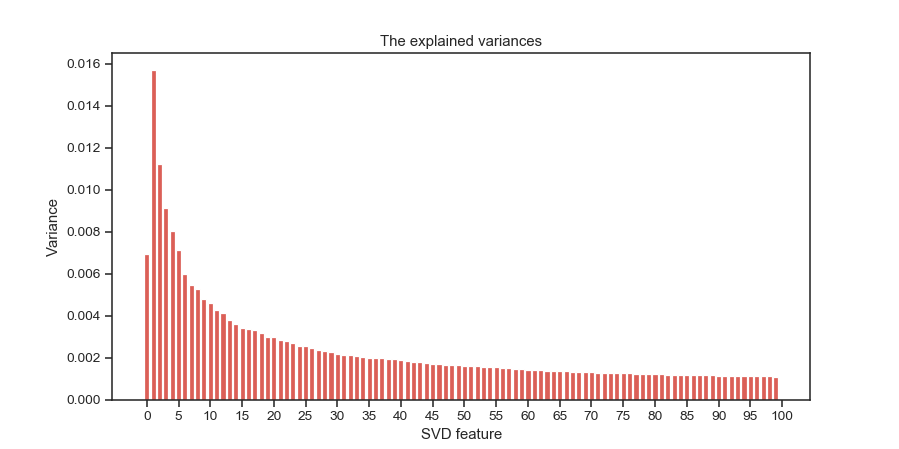

In [11]:
# Plot the explained variances
plt.figure(figsize=(10, 5))
features = range(100) 
plt.bar(features, svd1.explained_variance_[:100]) 
plt.xlabel('SVD feature')
plt.ylabel('Variance')
plt.xticks(range(0, 101, 5))
plt.title('The explained variances')
plt.show()

Let's use 13 features.

In [12]:
# Create a TruncatedSVD instance using the number of components
n = 13
svd1_n = TruncatedSVD(n_components=n)
svd1_n_features = svd1_n.fit_transform(tfidf_matrix_2)
svd1_n_features.shape

(61796, 13)

### 4.3. Applying K-Means model

In [15]:
# To decide the K value
from sklearn.cluster import KMeans
# Select k
ks1 = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 25]
inertias1 = []

for k in ks1:
    # Create a KMeans instance with k clusters: model
    model1 = KMeans(n_clusters=k)
    
    # Fit model to samples
    model1.fit(svd1_n_features)
    
    # Append the inertia to the list of inertias
    inertias1.append(model1.inertia_)

<IPython.core.display.Javascript object>


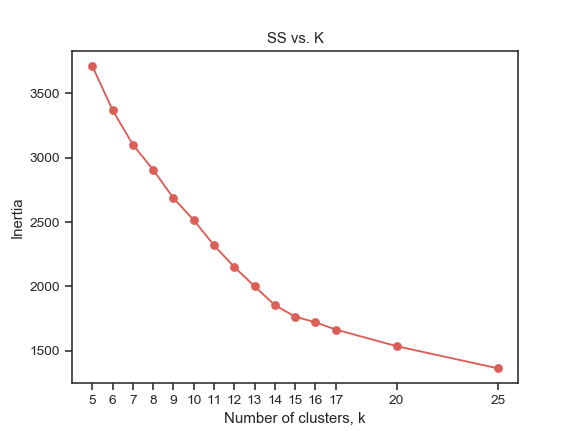

In [16]:
# Plot ks vs inertias
plt.figure()
plt.plot(ks1, inertias1, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks1)
plt.title('SS vs. K')
plt.show()

According to the plot, k is around 14. Let's check Silhouette score changing the k value. 

In [17]:
# Define Silhouette analysis
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

def silhouette(n_clusters, cluster_labels, features):
    '''
    Draw Shilhouette plot to various k
    '''

    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(7, 5)

    # the silhouette plot
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(features) + (n_clusters + 1) * 10])

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(features, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                                    facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    # Average silhouette score
    silhouette_avg = np.mean(sample_silhouette_values)
    print("For n_clusters =", n_clusters, ", The average silhouette_score is :", silhouette_avg)
    
    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.show()

In [18]:
# Define Silhouette analysis to k-means to decide k
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

def kmean_silhouette(min_k, max_k, interval_k, features):
    '''
    Do K-means and draw Shilhouette plot to various k
    '''
    range_n_clusters = [i for i in range(min_k, max_k+1, interval_k)]

    for n_clusters in range_n_clusters:
        # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(features)
        
        silhouette(n_clusters, cluster_labels, features)
        
    plt.show()

<IPython.core.display.Javascript object>


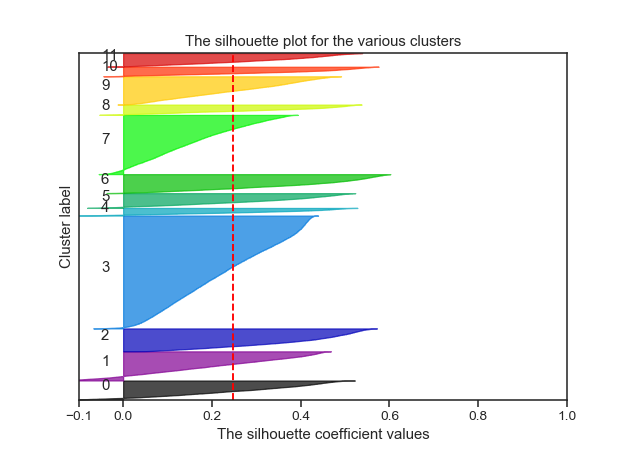

For n_clusters = 12 , The average silhouette_score is : 0.24657271431236236


<IPython.core.display.Javascript object>


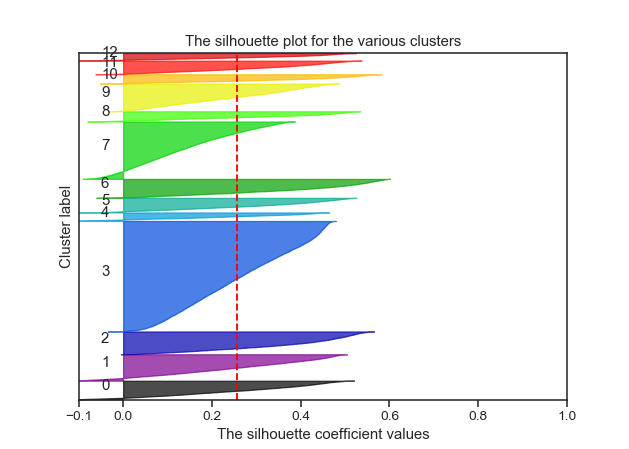

For n_clusters = 13 , The average silhouette_score is : 0.25668619139620724


<IPython.core.display.Javascript object>


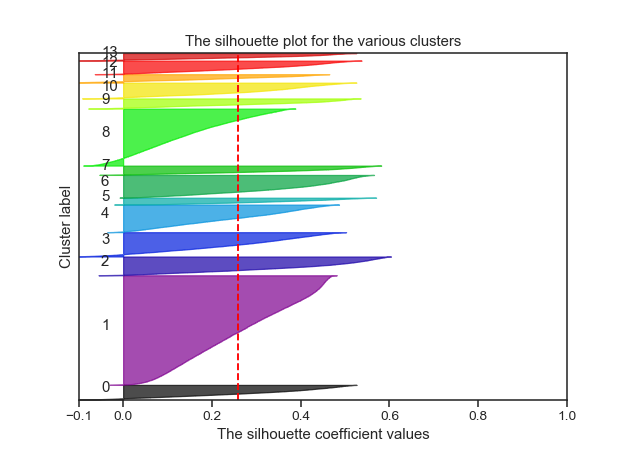

For n_clusters = 14 , The average silhouette_score is : 0.25950182223379636


<IPython.core.display.Javascript object>


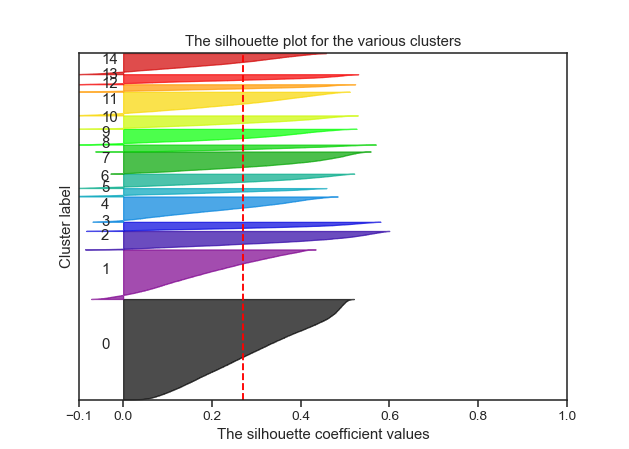

For n_clusters = 15 , The average silhouette_score is : 0.2701582129289374


<IPython.core.display.Javascript object>


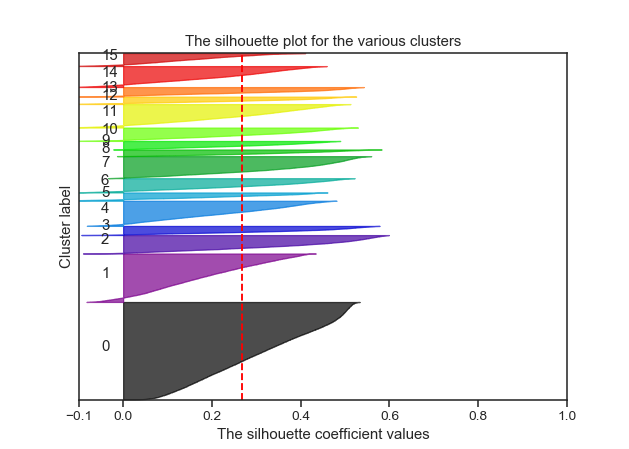

For n_clusters = 16 , The average silhouette_score is : 0.26863329458637814


<IPython.core.display.Javascript object>


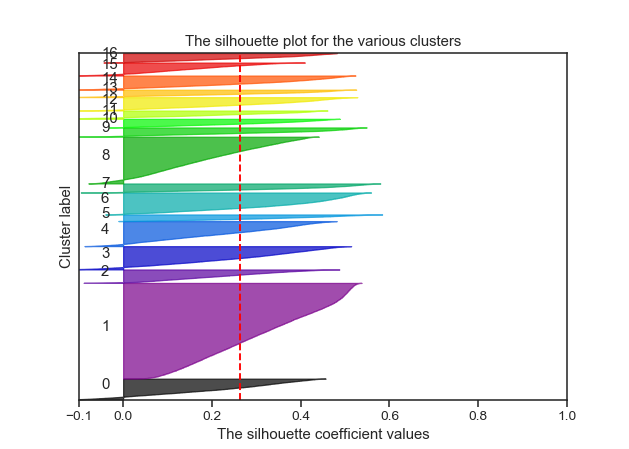

For n_clusters = 17 , The average silhouette_score is : 0.26320322333137297


<IPython.core.display.Javascript object>


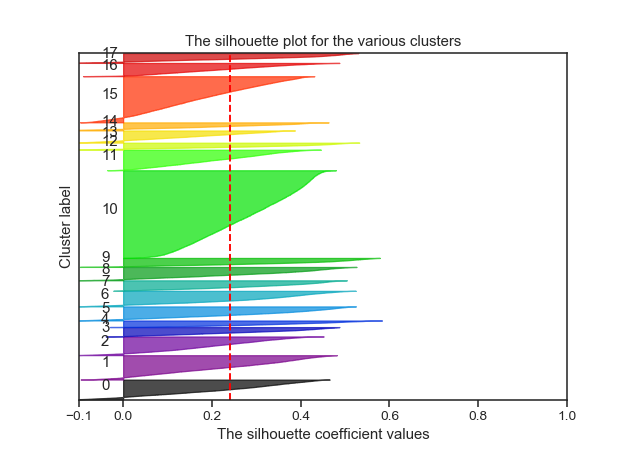

For n_clusters = 18 , The average silhouette_score is : 0.24064000259152624


In [20]:
# Silhouette plots when k = 12, 13, 14, 15, 16, 17, 18 (dimension = 13)
kmean_silhouette(12, 18, 1, svd1_n_features)

According to the silhouette scores and plots, k = 15 is the best.

In [21]:
# Try K-Means
k = 15
kmeans1 = KMeans(n_clusters=k)

label_kmean1 = kmeans1.fit_predict(svd1_n_features)

df_label_kmeans1 = product_name[['product_id', 'product_title']]
df_label_kmeans1['label'] = label_kmean1
df_label_kmeans1.head(10)

,product_id,product_title,label
0,3270,PETSOO Puppy Dog Pets Cute Winter Clothing Coa...,7
1,17464,"Beastie Bands ZEBRA Cat Collar, StripesBeastie...",2
2,19343,PetSafe PIF00-12917 Stay & Play Wireless Fence...,12
3,23478,YML Double Door Dog Kennel Cage with Plastic T...,0
4,52493,Hartz Groomer's Best Pedicure Kit for Dogs and...,9
5,69972,Espree Skin & Coat Care for PetsEspree Skin & ...,11
6,70064,Perfect Pet Soft Flap Cat Door with Telescopin...,2
7,82760,Landen 60P 25.4 Gallon Rimless Low Iron Aquari...,14
8,100975,Generic Dog Puppy Pet Rainbow Colorful Rubber ...,1
9,102579,"Weco Wonder Shell Natural Minerals (3 Pack), S...",14


<IPython.core.display.Javascript object>


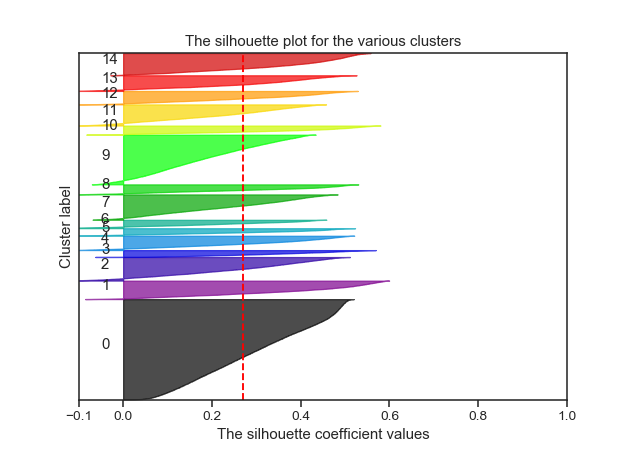

For n_clusters = 15 , The average silhouette_score is : 0.27007954938250706


In [22]:
# Silhouette plot
silhouette(15, label_kmean1, svd1_n_features)

In [23]:
# the sum-of-squares error
kmeans1.inertia_

1765.077146848804

**The other models**

1. DBSCAN: not good, got only two clusters

In [ ]:
# DBSCAN
from sklearn.cluster import DBSCAN

dbscan1 = DBSCAN(eps=0.02)
label_db1 = dbscan1.fit_predict(svd1_n_features)

df_label_db1 = product_name[['product_id', 'product_title']]
df_label_db1['label'] = label_db1
df_label_db1.head()

In [ ]:
set(label_db1)

C:\Users\namik\Anaconda3\envs\springboard1\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


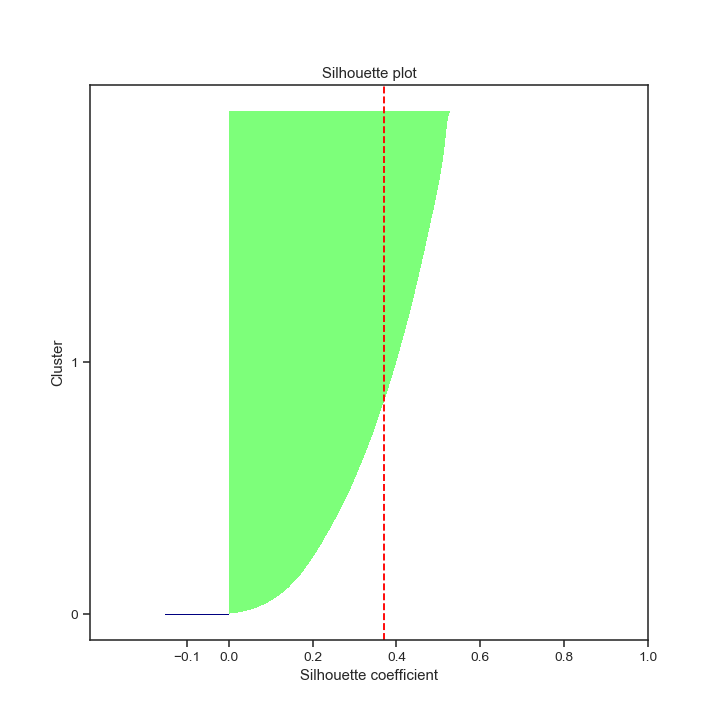

The average silhouette_score is : 0.3716394485687245


In [70]:
# Silhouette plot
silhouette_plot(label_db1, svd1_n_features)

C:\Users\namik\Anaconda3\envs\springboard1\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


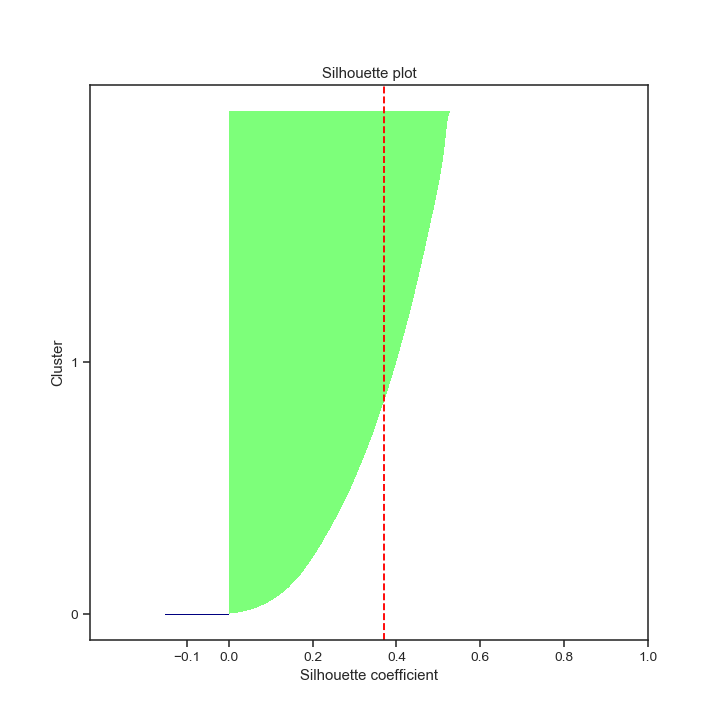

The average silhouette_score is : 0.3716394485687245


C:\Users\namik\Anaconda3\envs\springboard1\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


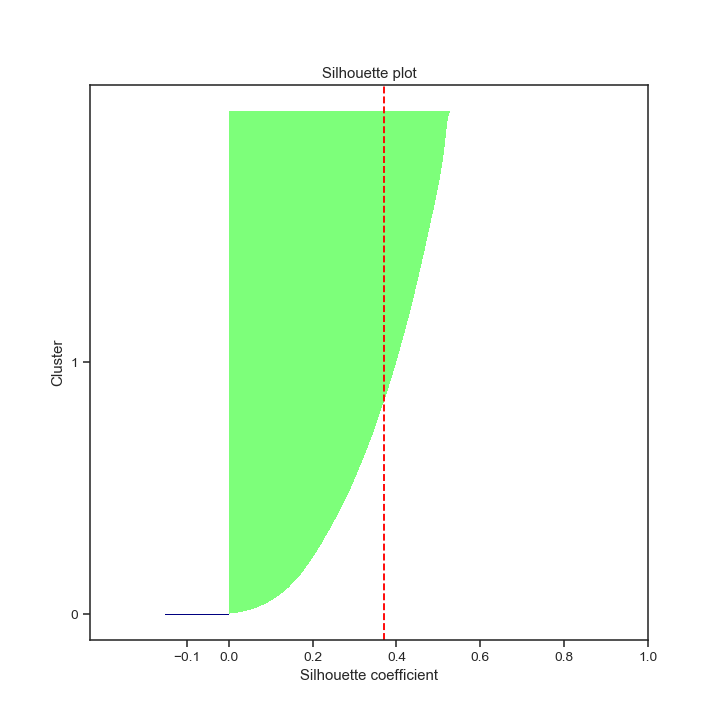

The average silhouette_score is : 0.3716394485687245


C:\Users\namik\Anaconda3\envs\springboard1\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


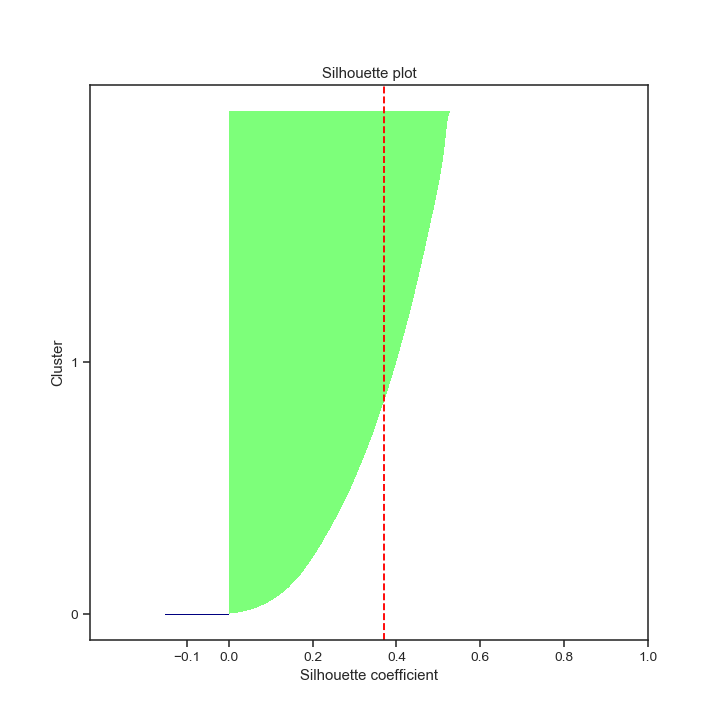

The average silhouette_score is : 0.3716394485687245


In [83]:
# DBSCAN
from sklearn.cluster import DBSCAN
epses = [0.05, 0.1, 0.15]

for i in epses:
    dbscan = DBSCAN(eps=i)
    label_db = dbscan1.fit_predict(svd1_n_features)
    
    # Silhouette plot
    silhouette_plot(label_db, svd1_n_features)

2. Affinity propagation: MemoryError

In [23]:
# Affinity propagation
from sklearn.cluster import AffinityPropagation

Aff1 = AffinityPropagation()
label_aff1 = Aff1.fit_predict(svd1_n_features)

df_label_aff1 = product_name[['product_id', 'product_title']]
df_label_aff1['label'] = label_aff1
df_label_aff1.head()

MemoryError: Unable to allocate 28.5 GiB for an array with shape (61796, 61796) and data type float64

3. Mean-shift: not good, got only two clusters

In [71]:
from sklearn.cluster import MeanShift

ms1 = MeanShift(seeds=svd1_n_features)
label_ms1 = ms1.fit_predict(svd1_n_features)

df_label_ms1 = product_name[['product_id', 'product_title']]
df_label_ms1['label'] = label_ms1
df_label_ms1.head()

[[ 0.12015731 -0.03038722  0.00152214 -0.03848991  0.01080679  0.00220317
   0.007025    0.00992317 -0.00333705 -0.00784524 -0.00409096 -0.00209521
  -0.00270592]
 [ 0.41487225 -0.29141214 -0.04202477 -0.18524623  0.10881872  0.03947082
  -0.16837394 -0.19282269 -0.22346347 -0.17418922 -0.06681692 -0.0347344
  -0.16807398]]


,product_id,product_title,label
0,3270,PETSOO Puppy Dog Pets Cute Winter Clothing Coa...,0
1,17464,"Beastie Bands ZEBRA Cat Collar, StripesBeastie...",0
2,19343,PetSafe PIF00-12917 Stay & Play Wireless Fence...,0
3,23478,YML Double Door Dog Kennel Cage with Plastic T...,0
4,52493,Hartz Groomer's Best Pedicure Kit for Dogs and...,0


4. VBGMM(Variational Bayesian Gaussian Mixture):  not good, very low Silhouette score

In [24]:
from sklearn.mixture import BayesianGaussianMixture

vbgm1 = BayesianGaussianMixture(n_components=15)
label_vbgm1 = vbgm1.fit_predict(svd1_n_features)

df_label_vbgm1 = product_name[['product_id', 'product_title']]
df_label_vbgm1['label'] = label_vbgm1
df_label_vbgm1.head()

C:\Users\namik\Anaconda3\envs\springboard1\lib\site-packages\sklearn\mixture\_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


,product_id,product_title,label
0,3270,PETSOO Puppy Dog Pets Cute Winter Clothing Coa...,10
1,17464,"Beastie Bands ZEBRA Cat Collar, StripesBeastie...",4
2,19343,PetSafe PIF00-12917 Stay & Play Wireless Fence...,4
3,23478,YML Double Door Dog Kennel Cage with Plastic T...,14
4,52493,Hartz Groomer's Best Pedicure Kit for Dogs and...,10


<IPython.core.display.Javascript object>


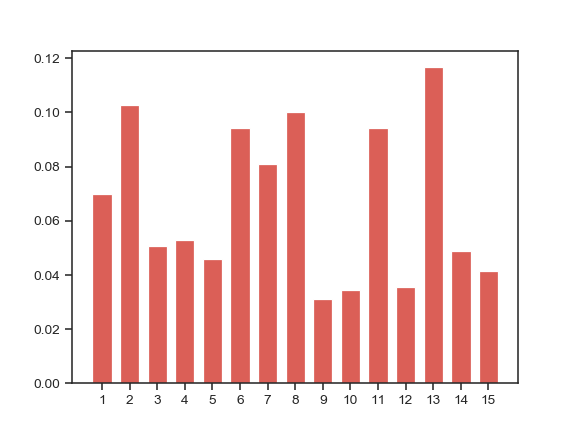

<function matplotlib.pyplot.show(*args, **kw)>

In [25]:
#print(vbgm.weights_)
plt.figure()
x_tick =np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.bar(x_tick, vbgm1.weights_, width=0.7, tick_label=x_tick)
plt.show

<IPython.core.display.Javascript object>


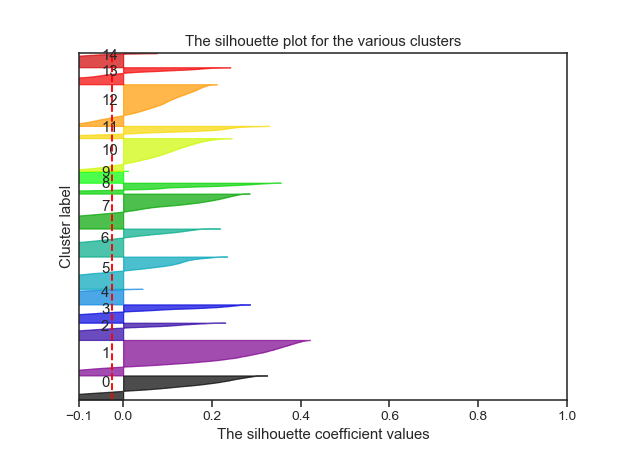

For n_clusters = 15 , The average silhouette_score is : -0.026065494857601988


In [26]:
# Silhouette plot
silhouette(15, label_vbgm1, svd1_n_features)

5. GMM: not good, very low Silhouette score

In [27]:
from sklearn.mixture import GaussianMixture

gmm1 = GaussianMixture(n_components=15)
label_gmm1 = gmm1.fit_predict(svd1_n_features)

df_label_gmm1 = product_name[['product_id', 'product_title']]
df_label_gmm1['label'] = label_gmm1
df_label_gmm1.head()

,product_id,product_title,label
0,3270,PETSOO Puppy Dog Pets Cute Winter Clothing Coa...,0
1,17464,"Beastie Bands ZEBRA Cat Collar, StripesBeastie...",11
2,19343,PetSafe PIF00-12917 Stay & Play Wireless Fence...,11
3,23478,YML Double Door Dog Kennel Cage with Plastic T...,2
4,52493,Hartz Groomer's Best Pedicure Kit for Dogs and...,0


<IPython.core.display.Javascript object>


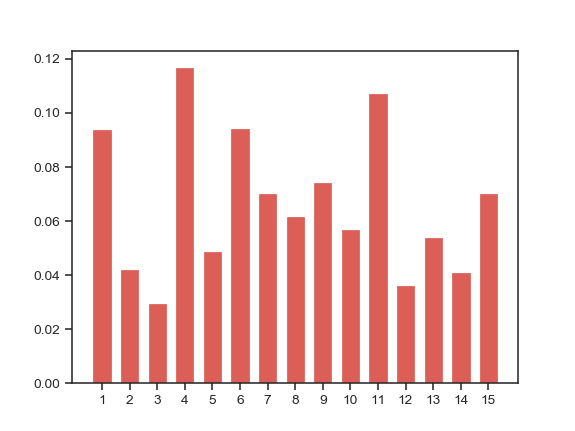

<function matplotlib.pyplot.show(*args, **kw)>

In [28]:
#print(vbgm.weights_)
plt.figure()
x_tick =np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.bar(x_tick, gmm1.weights_, width=0.7, tick_label=x_tick)
plt.show

<IPython.core.display.Javascript object>


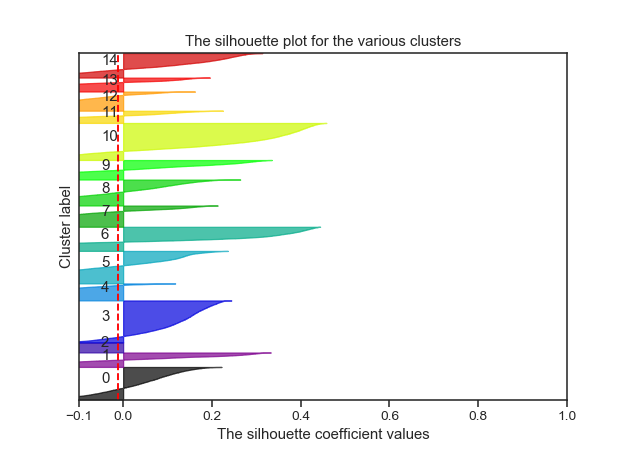

For n_clusters = 15 , The average silhouette_score is : -0.010475223593757162


In [29]:
# Silhouette plot
silhouette(len(set(label_gmm1)), label_gmm1, svd1_n_features)

6. Special Clustering: Memory error

In [82]:
from sklearn.cluster import SpectralClustering

spec1 = SpectralClustering(n_components=16, random_state=6)
label_spec1 = spec1.fit_predict(svd1_n_features)

df_label_spec1 = product_name[['product_id', 'product_title']]
df_label_spec1['label'] = label_spec1
df_label_spec1.head()

MemoryError: Unable to allocate 28.5 GiB for an array with shape (61796, 61796) and data type float64